### Установка необходимых библиотек

Для проведения манипуляций с изображениями нам необходима библиотека **OpenCV**, а также нужна библиотека для работы с **Face API**. Также подключим библиотеку **math** для использования некоторых математических операций и библиотеку **PIL** для работы с изображениями

In [79]:
import sys
!{sys.executable} -m pip install --quiet opencv-python azure-cognitiveservices-vision-face

In [80]:
import os, requests, glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
from PIL import Image  
import math

### Face API

Для нахождения опорных точек лица нам понадобится Face API. Запишем ключ и конечную точку в отдельные переменные.

In [81]:
key = '3eedbefda94449129615497638a01259' 
endpoint = 'https://slaerface.cognitiveservices.azure.com/' 

### Загружаем изображения

В папку `images` загружаем от 5 до 20 изображений (больше не рекомендуется, так как Face API за минуту распознает не более 20 изображений)

PS: лучше всего загрузить от 8 - 12 изображений :)
 
**ВАЖНО!** 
Нужно переименовать фотографии цифрами(порядковым номером): `1.jpg`, `2.jpg`, `3.jpg` ... и тд.

Пропустим фотографии из папки `images` через Face API для извлечения опорных точек лица. Сохраним картинки в список `images`, а коорданиты точек - в список `imagepoints`.

Анализируем изображение:  images/6.jpg
Обрабатываю картинку images/6.jpg  найдено 1 лиц
Обрабатываю картинку images/7.jpg  найдено 1 лиц
Обрабатываю картинку images/2.jpg  найдено 1 лиц
Обрабатываю картинку images/3.jpg  найдено 1 лиц
Обрабатываю картинку images/8.jpg  найдено 1 лиц
Обрабатываю картинку images/1.jpg  найдено 1 лиц
Обрабатываю картинку images/5.jpg  найдено 1 лиц
Обрабатываю картинку images/4.jpg  найдено 1 лиц


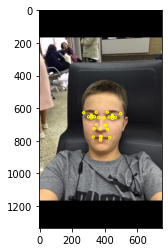

In [82]:
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))
face_url = 'https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg'
res = cli.face.detect_with_url(face_url,return_face_landmarks=True)


def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fn = glob.glob('images/*')[0]
print('Анализируем изображение: ',fn)

img = imread(fn)
cli.face.detect_with_url(face_url)
with open(fn,'rb') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)
for k,v in res[0].face_landmarks.as_dict().items():
    cv2.circle(img,(int(v['x']),int(v['y'])),7,(255,255,0),5)
plt.imshow(img)


filenames = []
images = []
imagepoints = []
cli.face.detect_with_url(face_url)
for fn in glob.glob("images/*")[0:20]:
    print("Обрабатываю картинку {} ".format(fn),end='')
    try:
        with open(fn,'rb') as f:
            res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    except:
        print(' - ОШИБКА - ',end='')
        res = []
    print(' найдено {} лиц'.format(len(res)))
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

## Аффинные преобразования

Далее совершим афинные преобразования, т.е повернем фотографии так, чтобы глаза находились на одном уровне

Будем ориентироваться на размер финального изображения $300\times300$ точек, тогда для координат глаз выберем точки $(130,120)$ и $(170,120)$. 


In [83]:
target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300


def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))


def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

Выровняем с её помощью все фотографии:

In [84]:
img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]

## Смешивание изображений

Для получения результата нам осталось смешать эти изображения. Это несложная задача, но мы используем очень мощную функцию усреднения, которая позволит нам в дальнейшем присваивать разные веса отдельным изображениям. 

In [85]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)/255.0
    return res

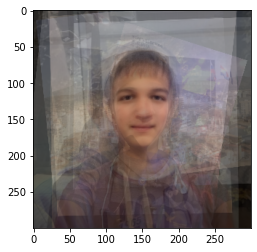

In [86]:
res = merge(img_aligned)
plt.imshow(res)

Сохраним полученный когнетивный портрет

In [87]:
res = merge(img_aligned,np.random.random(len(img_aligned)))
cv2.imwrite('res.jpg', (cv2.cvtColor(res,cv2.COLOR_BGR2RGB)*255.0).astype(np.int))

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


True

### "Жизнь"

Код ниже создаст композицию под названием "Жизнь". Когнетивный портрет, который находится в центре, был составлен из множества фотографий, которые являются эпизодами из жизни, и смотря на них, сразу приходят в голову определенный воспоминания, связанные с этими фотографиями. Подобно фильму, который составлен из множества кадров, наша жизнь тоже составлена и наполнена огромным количеством разных запонимающихся моментов. Вокруг когнетивного портрета расположены все фотографии отдельно. Вообще, сама картина это часы жизни. Стрелки часов посередине(на когнетивном портрете) показывают на отдельные фотографии, символизируя течение жизни. Фотографии в отдельности - это воспоминания и отдельные друг от друга моменты, но все вместе они - это уже целая жизнь(или ее часть)

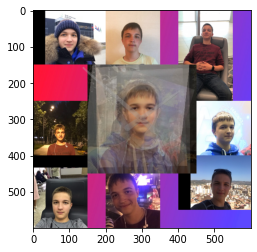

In [88]:
width = 600
height = 600
line = len(images)

img = Image.open('bg.jpg').resize((width, height))
cognitivePortrait = Image.open('res.jpg')
arrow = Image.open('arrow.png')
arrow = arrow.resize((600, 600))

cur = 0
flag = False
for x in range(1, len(images) + 1):
    imgNew = Image.open('images/' + str(x) + '.jpg')
    imgNew = imgNew.resize((round(imgNew.size[0] / 5), round(imgNew.size[1] / 5)))
    if cur < math.ceil((line - 2) / 2):
        k = int(cur * (600 / ((line - 2) / 2)))
        img.paste(imgNew, (k, 0))
        cur += 1
    else:
        if cur < math.ceil((line - 2) / 2) + 2 and flag is True:
            img.paste(imgNew, (450, 250))
            cur += 1
            continue
        if cur < math.ceil((line - 2) / 2) + 2 and flag is False:
            img.paste(imgNew, (0, 250))
            cur += 1
            flag = True
        else:
            k = int((cur - (math.ceil((line - 2) / 2) + 2)) * (600 / ((line - 2) / 2)))
            img.paste(imgNew, (k, 400))
            cur += 1     
img.paste(cognitivePortrait, (150, 150))
img.paste(arrow, (0, 0), mask=arrow)
plt.imshow(img)

In [89]:
img.save('life.jpg')